# <center>Data Mining Project: Brain Tumor Detection</center>
## <center>Sanjay Jars</center>
## <center>DSC 550</center>
## <center>Bellevue University</center>



With every year, the number of patients with a brain tumor is increasing. There are two classes of brain tumors, primary and secondary tumors. Primary tumors have several types; one of the frequently found is a meningioma type. This type of tumors found near the top and outer curve of the brain. Meningioma is slowly growing noncancerous tumors that cause seizures and visual problems. Glioma is an abnormal growth in glial cells present around the neurons in the brain. Pituitary tumors grow in pituitary glands that affect body functions.<br /> It is a very difficult to locate, detect, and select the infected tumor portion in the brain from the MRI (Magnetic resonance images). This tedious and time-consuming task is performed by radiologists and medical field experts. The accuracy of this task is mainly dependent on the experience and expertise of the person performing this task. So, if we use a machine learning model to perform this task, it will help to overcome the shortcomings with the person involved in performing this task. So, I think if we can automate this process of classifying the tumors by using machine learning algorithms it will improve the accuracy of the results and cost due to the expertise required. If we correctly classify the tumors, the specific treatment to that type can be applied. The accurate information about type and location helps in planning the surgical process for its removal.<br /> I will be following an approach involving image preprocessing like segmentation, extraction, and classification. The segmentation will be used to segment and divide the tumor region. The extraction will be used to extract information from the segmented image. Classification will help to compare the extracted information with information from the available dataset. Image pre-processing will be performed to reduce the noise level in the image. For segmentation, I am thinking about using K-means unsupervised algorithm. Then we can use a Support vector machine that can be used to classify the segmented image. Once the model is trained, we can give new images and the model will predict the class for the new image. I time permits I would also like to create a CNN model for prediction. I will be using the brain tumor images dataset from https://figshare.com/articles/brain_tumor_dataset/1512427. This dataset contains 3064 T1-weighted contrast-enhanced images from 233 patients with three kinds of brain tumors. The data is organized in the MATLAB data format (.mat file). Each file stores a struct containing the following fields for an image: cjdata.label: 1 for meningioma, 2 for glioma, 3 for pituitary tumor cjdata.PID: patient ID cjdata.image: image data cjdata.tumorBorder: a vector storing the coordinates of discrete points on tumor border. cjdata.tumorMask: a binary image with 1s indicating tumor region. I am planning to measure the accuracy of classification by testing the model with the test data set. The accuracy of the model can be majored by using the confusion matrix. I will be creating some visualization for images that can compare original images with segmented images. 

https://pdfs.semanticscholar.org/b70e/4a5455a4531ca650272474d49d29e5e1da5c.pdf<br /> 
https://figshare.com/articles/brain_tumor_dataset/1512427


In [1]:
import concurrent.futures as cf
import os
import random
import time
import cv2

import h5py as h5  # library to load HDF5 binary file format
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
from matplotlib import __version__ as mpv
from sklearn import preprocessing
from sklearn.cluster import MiniBatchKMeans
from sklearn.model_selection import GridSearchCV, train_test_split
from keras.models import Sequential
from keras.layers import ZeroPadding2D, MaxPool2D,Conv2D,BatchNormalization,Activation,Flatten,Dense, Input

print("Using version %s of pandas" % pd.__version__)
print("Using version %s of matplotlib" % mpv)
print("Using version %s of seaborn" % sns.__version__)
print("Using version %s of sklearn" % sklearn.__version__)
print("Using version %s of numpy" % np.__version__)
print("Using version %s of h5py" % h5.__version__)

Using version 1.0.5 of pandas
Using version 3.2.2 of matplotlib
Using version 0.10.1 of seaborn
Using version 0.23.1 of sklearn
Using version 1.18.5 of numpy
Using version 2.10.0 of h5py


### Configurations

In [3]:
seed = 13
random.seed(seed)
folder = "original-mat-files"
target_folder = "converted-images/"

### Scan Source .mat files

In [29]:
onlyfiles = [os.path.join(folder, f) for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f)) and f.endswith(".mat")]
os.makedirs(target_folder, exist_ok=True)

### Utility class to parse the .mat file and read contents

In [5]:
class MatImage(object):
    patient_id = ""
    image = ""
    label = ""
    tumor_border = ""
    tumor_mask = ""
    file_name = ""

    def __init__(self, file_name, file_path=None):
        path = file_name
        if file_path is not None:
            path = os.path.join(file_path, file_name)
        f = h5.File(path, "a")

        self.file_name = file_name
        self.image = np.mat(f["/cjdata/image"])
        self.patient_id = np.array(f["/cjdata/PID"])
        self.label = np.array(f["/cjdata/label"])
        self.tumor_border = np.mat(f["/cjdata/tumorBorder"])
        self.tumor_mask = np.mat(f["/cjdata/tumorMask"])

    # function to plot image with mask
    def draw_image_with_mask(self):
        ax = sns.heatmap(self.tumor_mask, alpha=0.2)
        ax = sns.heatmap(self.image)
        plt.show()

    # Function to apply medain filter on image for removing noise
    def get_median_filtered_image(self, filter_size=2):
        return ndimage.median_filter(self.image, filter_size)

    def tostring(self):
        result = "Patient Id:"
        for pid in self.patient_id:
            result += str(id) + ","
        result += " label"
        for label in self.label:
            result += str(label) + ","
        result += "File Name:" + self.file_name
        return result

### Original images

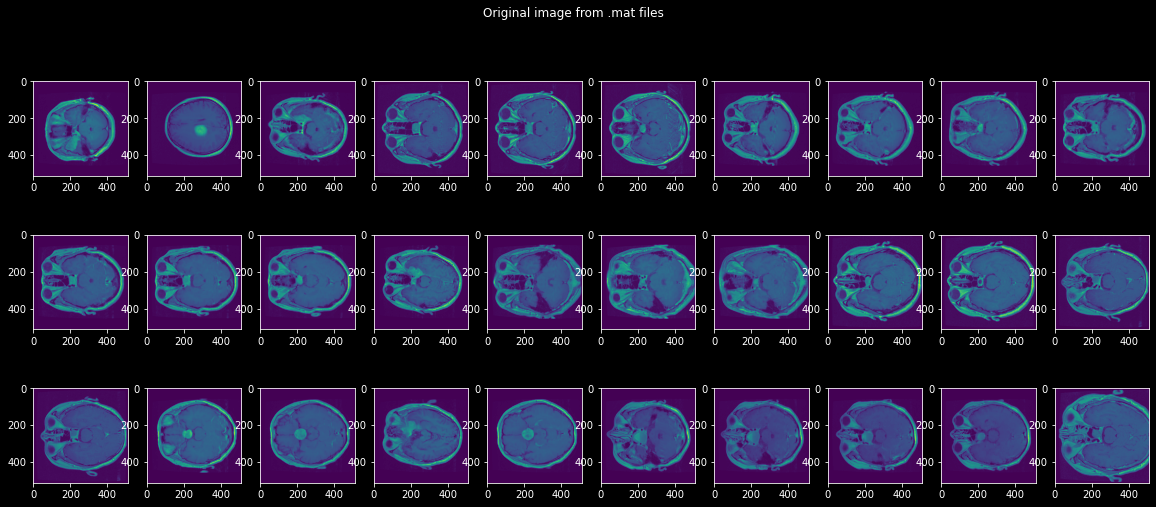

In [30]:
plt.rcParams["figure.figsize"] = [20, 8]
fig, axs = plt.subplots(3, 10)
i = 0
for filepath in onlyfiles:
    p1 = MatImage(onlyfiles[i])
    axs[int(i/10), i%10].imshow(p1.image)
    i += 1
    if i>=30:
        break
plt.suptitle("Original image from .mat files")    
plt.show()    
del p1

### Image with mask plotted on top of image

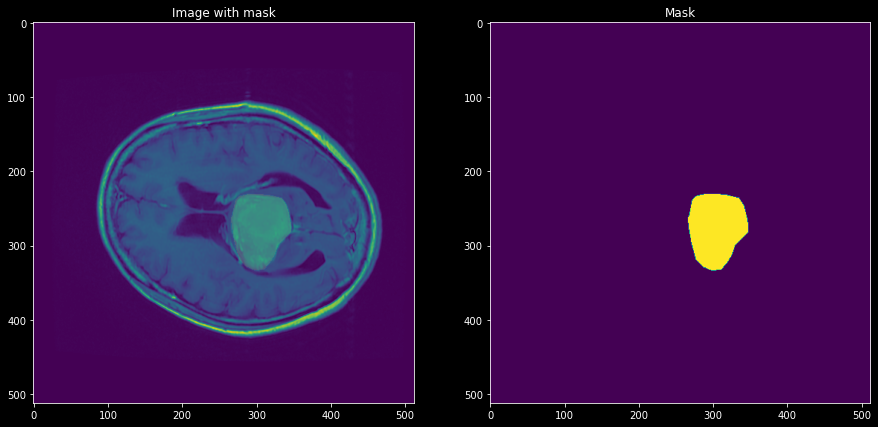

In [31]:
p1 = MatImage(folder+"/22.mat")
plt.rcParams["figure.figsize"] = [15, 8]
fig, axs = plt.subplots(1, 2)
axs[0].imshow(p1.image)
axs[0].imshow(p1.tumor_mask, alpha=0.1)
axs[0].set(title="Image with mask")
axs[1].imshow(p1.tumor_mask)
axs[1].set(title="Mask")
plt.show()

### Read mat files 
### 1. Use median filter to enhance images
### 2. Crop the images to only contain actual brain image and remove extra image parts
### 3. Resize all images to 256*256 dimension

In [8]:
IMG_SIZE = (256, 256)


def crop_image(image_path, IMG_SIZE=(256, 256)):
    # read image
    img = cv2.imread(image_path)
    # resize image to smaller dimensions
    img = cv2.resize(img, dsize=IMG_SIZE, interpolation=cv2.INTER_CUBIC)
    # convert to gray
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # add some blurring
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    # threshold the image, then perform a series of erosions +
    # dilations to remove any small regions of noise
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)

    # find the extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])

    # add contour on the image
    img_cnt = cv2.drawContours(img.copy(), [c], -1, (0, 255, 255), 4)

    # add extreme points
    img_pnt = cv2.circle(img_cnt.copy(), extLeft, 8, (0, 0, 255), -1)
    img_pnt = cv2.circle(img_pnt, extRight, 8, (0, 255, 0), -1)
    img_pnt = cv2.circle(img_pnt, extTop, 8, (255, 0, 0), -1)
    img_pnt = cv2.circle(img_pnt, extBot, 8, (255, 255, 0), -1)

    # crop
    ADD_PIXELS = 0
    new_img = img[
        extTop[1] - ADD_PIXELS : extBot[1] + ADD_PIXELS,
        extLeft[0] - ADD_PIXELS : extRight[0] + ADD_PIXELS,
    ].copy()
    # resize image to input dimensions after cropping
    new_img = cv2.resize(new_img, dsize=IMG_SIZE, interpolation=cv2.INTER_CUBIC)
    #return gray scale image
    gray = cv2.cvtColor(new_img, cv2.COLOR_RGB2GRAY)
    return gray


Function to save image as png

In [9]:
def save_image(image_array, file_path, format="png"):
    fig, ax = plt.subplots()
    im = ax.imshow(image_array)
    plt.imsave(
        file_path, image_array, format=format,
    )
    plt.close(fig)

Transform files as mentioned above and save them

def save_filese_as_image(mat_file_path):
    # read input .mat file
    mat_image = MatImage(mat_file_path)
    filename = mat_image.file_name.split("/")[-1].split(".")[0]
    target_file_path = target_folder + filename + "_" + str(int(mat_image.label[0][0])) + ".png"
    # save image after applying median filter
    save_image(mat_image.get_median_filtered_image(), target_file_path) 
    # apply cropping
    conv_image = crop_image(target_file_path)
    # save image again
    save_image(conv_image, target_file_path) 

# use multiple cores for above operation 
start_time = time.time()
with cf.ProcessPoolExecutor() as executor:
        results = executor.map(save_filese_as_image, onlyfiles)
print(f"--- {(time.time() - start_time)} seconds for transforming {len(onlyfiles)} files---"  )

### Scan all converyed image files

In [32]:
onlyfiles = [os.path.join(target_folder, f) for f in os.listdir(target_folder) if os.path.isfile(os.path.join(target_folder, f)) and f.endswith(".png")]

### Images after above transformations

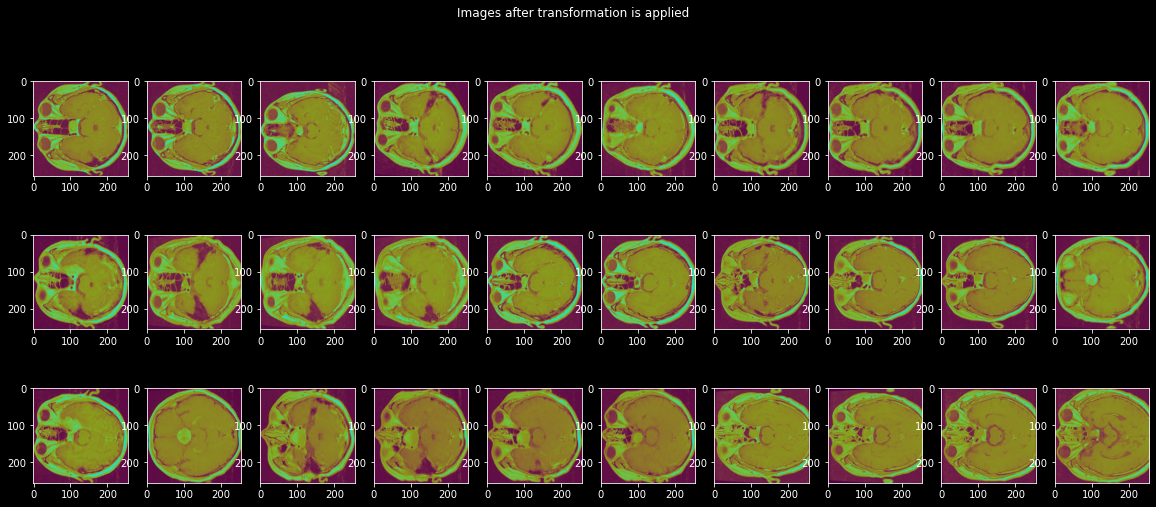

In [33]:
plt.rcParams["figure.figsize"] = [20, 8]
fig, axs = plt.subplots(3, 10)
i = 0
for filepath in onlyfiles:
    img = cv2.imread(filepath)
    axs[int(i/10), i%10].imshow(img)
    i += 1
    if i>=30:
        break
plt.suptitle("Images after transformation is applied")    
plt.show()    
del img

### Function to load all images into numpy arrays with labels

In [35]:
def load_image(image_path):
    img = cv2.imread(image_path)
    # enable this to remove last dimension 3
    #img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    filename = image_path.split("/")[-1].split(".")[0]
    label = filename.split("_")[-1]
    return img, int(label), filename

def get_data_set(for_cnn=False):
    images = []
    labels = []

    filenames = []
    with cf.ProcessPoolExecutor() as executor:
        results = executor.map(load_image, onlyfiles)
        
    for result in results:
        if result[0] is not None:
            if result[0].shape[0] != 256 or result[0].shape[1] != 256:
                print("Dropping image as dimensions are not correct", result[2])
            else:
                image = result[0]
                if for_cnn:
                    # images.append(image)
                    if result[1] == 1:
                        labels.append([1, 0, 0])
                    elif result[1] == 2:
                        labels.append([0, 1, 0])
                    else:
                        labels.append([0, 0, 1])
                else:
                    labels.append(result[1])
                images.append(cv2.cvtColor(image, cv2.COLOR_RGB2GRAY))
                filenames.append(result[2])
    output_image = np.empty((len(images), 256, 256))

    for i in range(len(images)):
        output_image[i] = images[i]

    return output_image, np.array(labels)

### Load all images

In [36]:
start_time = time.time()
dataset_x, dataset_y = get_data_set()
print("Shape of dataset-X", dataset_x.shape)
print("Shape of dataset-Y", dataset_y.shape)
print(f"--- {(time.time() - start_time)} seconds for loading {len(dataset_x)} files---"  )

Shape of dataset-X (3064, 256, 256)
Shape of dataset-Y (3064,)
--- 4.023566007614136 seconds for loading 3064 files---


### Reshape the datasets 

In [37]:
print("dataset_x:", dataset_x.shape)
X = dataset_x.reshape(len(dataset_x), -1)
print("X:", X.shape)
print("dataset_y:", dataset_y.shape)
y = dataset_y.reshape(len(dataset_y), -1)
print("y:",dataset_y.shape)


dataset_x: (3064, 256, 256)
X: (3064, 65536)
dataset_y: (3064,)
y: (3064,)


In [38]:
scaler = preprocessing.StandardScaler().fit(X)
X = scaler.fit_transform(X)
print(X.shape)


(3064, 65536)


In [39]:
print(X[0])

[1.4552018  2.23997055 2.17001445 ... 0.59236561 0.89653184 0.69184858]


### Split dataset into training and test set

In [40]:
train_x, test_x, train_y, test_y, = train_test_split(
    X, y, train_size=0.80, random_state=seed
)
print("Training Set length", len(train_x))
print("Test Set length",len(test_x))


Training Set length 2451
Test Set length 613


### Number of clusters in data

In [41]:
n_clusters = len(np.unique(dataset_y))
print(n_clusters)

3


In [42]:
from sklearn import metrics
from sklearn.cluster import KMeans

labels = train_y


def bench_k_means(estimator, name, data, y=None):
    t0 = time.time()
    estimator.fit(data, y)
    inertia = None
    try:
        inertia = estimator.inertia_
    except AttributeError:
        inertia = None
    

    print(
        "%-9s\t%.2fs\t%i\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f"
        % (
            name,
            (time.time() - t0),
            inertia,
            metrics.homogeneity_score(labels, estimator.labels_),
            metrics.completeness_score(labels, estimator.labels_),
            metrics.v_measure_score(labels, estimator.labels_),
            metrics.adjusted_rand_score(labels, estimator.labels_),
            metrics.adjusted_mutual_info_score(labels, estimator.labels_),
            metrics.silhouette_score(
                data, estimator.labels_, metric="euclidean", sample_size=sample_size
            ),
        )
    )

In [43]:
sample_size = 300
mini_batch = MiniBatchKMeans(
    init="k-means++",
    n_clusters=n_clusters,
    n_init=10,
    random_state=seed,
    batch_size=sample_size,
    max_iter=300,
)
stats = sklearn.model_selection.cross_validate(mini_batch, train_x, train_y, cv=5, return_estimator=False)
print(stats)

KeyboardInterrupt: 

K-means is not 

In [19]:
del dataset_x, dataset_y, train_x, train_y

NameError: name 'dataset_X' is not defined

In [20]:
start_time = time.time()
dataset_xc, dataset_yc = get_data_set(for_cnn=True)
print("Shape of dataset-X", dataset_xc.shape)
print("Shape of dataset-Y", dataset_yc.shape)
print(f"--- {(time.time() - start_time)} seconds for loading {len(dataset_xc)} files---"  )

Shape of dataset-X (3064, 256, 256)
Shape of dataset-Y (3064, 3)
--- 34.207903146743774 seconds for loading 3064 files---


In [21]:
print("dataset_yc:", dataset_yc.shape)
yc = dataset_yc.reshape(len(dataset_yc), -1)
print("yc:",yc.shape)
print("dataset_yc:", dataset_xc.shape)
xc = dataset_xc.reshape(len(dataset_xc), -1)
xc.shape
print("xc:",xc.shape)

dataset_yc: (3064, 3)
yc: (3064, 3)
dataset_yc: (3064, 256, 256)
xc: (3064, 65536)


### Normalize image data

### Split dataset in testsets and training sets

In [24]:
train_xc, test_xc, train_yc, test_yc, = train_test_split(
    xc, yc, train_size=0.80, random_state=seed
)
print("Training Set length", len(train_xc))
print("Test Set length",len(test_xc))

Training Set length 2451
Test Set length 613


In [25]:
train_xc.shape

(2451, 65536)

In [26]:


def create_keras_model(input_shape):
    model = Sequential()
    model.add(Input(input_shape))
    model.add(BatchNormalization(axis=1, name="bn0"))
    model.add(Dense(10000))
    model.add(Activation("relu"))
    model.add(Flatten())
    model.add(Dense(3, activation="softmax"))

    model.compile(
        loss="categorical_crossentropy", optimizer="sgd", metrics=["accuracy"]
    )

    return model



In [27]:
IMG_SHAPE = 65536
for batch_size in [30]:
    model = create_keras_model(IMG_SHAPE)
    model.summary()
    model.fit(
        x=train_xc,
        y=train_yc,
        batch_size=batch_size,
        epochs=25,
        validation_split=0.2,
        verbose=1,
    )

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bn0 (BatchNormalization)     (None, 65536)             262144    
_________________________________________________________________
dense (Dense)                (None, 10000)             655370000 
_________________________________________________________________
activation (Activation)      (None, 10000)             0         
_________________________________________________________________
flatten (Flatten)            (None, 10000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 30003     
Total params: 655,662,147
Trainable params: 655,531,075
Non-trainable params: 131,072
_________________________________________________________________
Epoch 1/25
66/66 [==============================] - 5s 83ms/step - loss: 2.1056 - accuracy: 0.7423 - v

In [ ]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
import keras.utils as ku

model = KerasClassifier(build_fn=create_keras_model, epochs=10, batch_size=30, verbose=1)
kfold = StratifiedKFold(n_splits=2, shuffle=True, random_state=seed)
results = cross_val_score(model, train_xc, ku.to_categorical(train_yc), cv=kfold)
print(results.mean())